In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

import operator
import heapq


import warnings
warnings.filterwarnings('ignore')

In [2]:
book_ratings = pd.read_csv('book_ratings.csv')
book_ratings.head()

,user_id,book_id,title,rating
0,314,1,Harry Potter and the Half-Blood Prince (Harry ...,5
1,439,1,Harry Potter and the Half-Blood Prince (Harry ...,3
2,588,1,Harry Potter and the Half-Blood Prince (Harry ...,5
3,1169,1,Harry Potter and the Half-Blood Prince (Harry ...,4
4,1185,1,Harry Potter and the Half-Blood Prince (Harry ...,4


In [3]:
print (f'Number of ratings in dataset: {book_ratings.shape[0]}')

Number of ratings in dataset: 79701


In [4]:
util_matrix = book_ratings.pivot_table(index=['user_id'], 
                                       columns=['title'],
                                       values='rating') 
util_matrix.shape


(28906, 812)

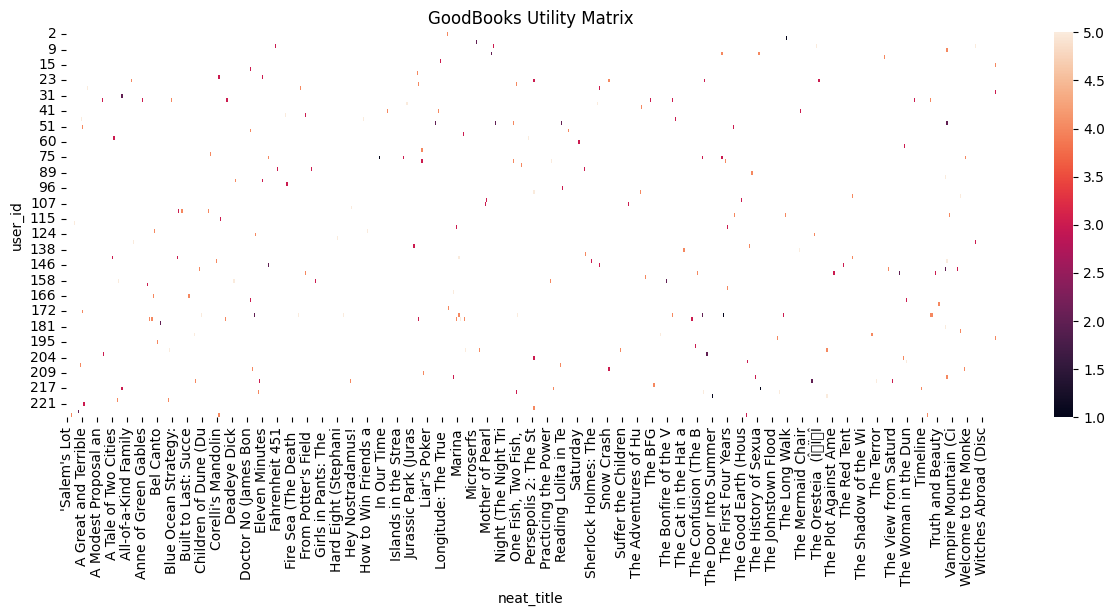

In [5]:
book_ratings['neat_title'] = book_ratings['title'].apply(lambda x: x[:20])
util_matrix_neat = book_ratings.pivot_table(index=['user_id'], 
                                            columns=['neat_title'],
                                            values='rating')

fig, ax = plt.subplots(figsize=(15,5))

_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('GoodBooks Utility Matrix')


In [6]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [7]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_norm.columns, 
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix  
user_sim_df[:5]

user_id,7,10,23,27,35,41,46,47,49,51,...,53364,53366,53372,53373,53378,53381,53393,53403,53406,53420
user_id,,,,,,,,,,,,,,,,,,,,,
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.177657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
    if user not in user_sim_df.columns:
        return book_ratings.groupby('title').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users
    
    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())
        
    # Loop over each user's favourite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]: 
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N 

In [9]:
collab_generate_top_N_recommendations(314)

['Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'The Lord of the Rings: Weapons and Warfare',
 "I'm a Stranger Here Myself: Notes on Returning to America after Twenty Years Away",
 'Treasure Island',
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
 'Children of Dune (Dune Chronicles #3)',
 'The Broken Wings',
 'Neither Here nor There: Travels in Europe',
 'The Power of One (The Power of One, #1)']

In [10]:
# User 314's historical ratings
book_ratings[book_ratings['user_id'] == 314][:][['title','rating']].sort_values(by='rating', ascending=False)[:10]

,title,rating
0,Harry Potter and the Half-Blood Prince (Harry ...,5
401,Harry Potter and the Goblet of Fire (Harry Pot...,5
300,Harry Potter and the Prisoner of Azkaban (Harr...,4
1900,The Lord of the Rings: Weapons and Warfare,4
1600,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4
4000,The Door Into Summer,4
7501,Memories of My Melancholy Whores,4
2501,Dune Messiah (Dune Chronicles #2),4
1500,The Mother Tongue: English and How It Got That...,3
2400,Chapterhouse: Dune (Dune Chronicles #6),3


In [11]:
def collab_generate_rating_estimate(book_title, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values 
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user
    
    # Create a weighted sum for each of the k users who have rated the 
    # reference item (book).
    for sim_idx, user_id in enumerate(sim_users):
        # User's rating of the item
        rating = util_matrix.loc[user_id, book_title]
        # User's similarity to the reference user 
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to 
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list) 
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average 
        # rating given by all users for the item.  
        predicted_rating = np.mean(util_matrix[book_title])
    return predicted_rating

In [12]:
title = "The Lord of the Rings: Weapons and Warfare"
actual_rating = book_ratings[(book_ratings['user_id'] == 314) & (book_ratings['title'] == title)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(book_title = title, user = 314)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - The Lord of the Rings: Weapons and Warfare
---
Actual rating: 		 4
Predicted rating: 	 4.432698712267664


In [14]:
# Calculate Mean Absolute Error (MAE) - Model Performance Metric
predictions = []
actuals = []

# Test on a sample of 50 user-book pairs
sample_data = book_ratings.sample(n=min(50, len(book_ratings)), random_state=42)

for idx, row in sample_data.iterrows():
    user = row['user_id']
    book = row['title']
    actual = row['rating']
    
    try:
        predicted = collab_generate_rating_estimate(book_title=book, user=user)
        predictions.append(predicted)
        actuals.append(actual)
    except:
        continue

# Calculate MAE
mae = np.mean([abs(p - a) for p, a in zip(predictions, actuals)])
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Tested on {len(predictions)} user-book pairs")
print(f"Average rating scale is 1-5, so MAE of {mae:.3f} means predictions are off by ~{mae:.2f} points on average")

Mean Absolute Error (MAE): 0.584
Tested on 36 user-book pairs
Average rating scale is 1-5, so MAE of 0.584 means predictions are off by ~0.58 points on average


In [13]:
import pickle

# Save the expensive-to-compute objects
data_to_save = {
    'book_ratings': book_ratings,
    'util_matrix': util_matrix,
    'util_matrix_sparse': util_matrix_sparse,
    'user_sim_df': user_sim_df,
    'util_matrix_norm': util_matrix_norm,
    'util_matrix_neat': util_matrix_neat
}

with open('collaborative_filter_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Data saved successfully!")

# To load the data later, use:
# with open('collaborative_filter_data.pkl', 'rb') as f:
#     data = pickle.load(f)
#     book_ratings = data['book_ratings']
#     util_matrix = data['util_matrix']
#     util_matrix_sparse = data['util_matrix_sparse']
#     user_sim_df = data['user_sim_df']
#     util_matrix_norm = data['util_matrix_norm']
#     util_matrix_neat = data['util_matrix_neat']

Data saved successfully!
